In [1]:
import pandas as pd
import numpy as np
import sklearn
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
import tensorflow as tf
from tqdm import tqdm
import re
import scipy
import tensorflow
from tensorflow.keras.layers import Input,Flatten, Embedding, Reshape, Multiply, Dropout, Dense, Concatenate, GlobalAveragePooling1D
from tensorflow.keras.layers import Layer, SpatialDropout1D, GlobalMaxPooling1D, Bidirectional, GRU, LSTM
from tensorflow.keras.layers import Dot, TimeDistributed, BatchNormalization, Add, multiply
from tensorflow.keras import initializers, regularizers, constraints
from tensorflow.keras import Model
from tensorflow.keras.optimizers import Adam
#import keras.backend as K
from sklearn.utils import shuffle
import seaborn as sns
import math
import collections
from collections import Counter
import matplotlib.pyplot as plt

In [2]:
import shap
print(shap.__version__)

0.39.0


In [3]:
PATH = "../data/mind_small/"
news = pd.read_csv(PATH + "news.tsv",header=None, sep="\t")
behaviors = pd.read_csv(PATH + "behaviors.tsv", header=None, sep="\t")
news.columns = ["news_id", "category", "sub_category", "title", "abstract", "url", "title_entities", "abstract_entities"]
behaviors.columns = ["idx", "user_id", "time", "history", "impressions"]
behaviors = behaviors.drop_duplicates(["user_id", "history"]) 
behaviors.dropna(subset=["user_id", "history"], inplace=True)

In [4]:
sessions = {}
for idx, row in behaviors.iterrows():
    sessions[row["user_id"]] = row["history"].split(" ")

users = []
clicks = []
for k, v in sessions.items():
    for elem in v:
        users.append(k)
        clicks.append(elem)

tuples = list(zip(users, clicks))
interactions = pd.DataFrame(tuples, columns=["user", "news_id"])
interactions = interactions[:10000]

In [5]:
merged = interactions.merge(news, on=["news_id"])
merged.head(1)

,user,news_id,category,sub_category,title,abstract,url,title_entities,abstract_entities
0,U13740,N55189,tv,tvnews,"'Wheel Of Fortune' Guest Delivers Hilarious, O...","We'd like to solve the puzzle, Pat: Blair Davi...",https://assets.msn.com/labs/mind/AAIORni.html,[],"[{""Label"": ""Pat Sajak"", ""Type"": ""P"", ""Wikidata..."


In [6]:
print(len(merged))
merged = merged.drop_duplicates()
print(len(merged))

10000
9861


# 1. Preprocessing

In [7]:
# remove users which have fewer than 5 interacations
print("Len before removal: ",len(merged))
_keys = merged["user"].value_counts()[merged["user"].value_counts() > 5].keys()
merged = merged[merged["user"].isin(_keys)]
print("Len after removal: ",len(merged))


user_enc = LabelEncoder()
article_enc = LabelEncoder()
merged["user_id"] = user_enc.fit_transform(merged["user"].values)
merged["article_id"] = article_enc.fit_transform(merged["news_id"].values)




Len before removal:  9861
Len after removal:  9728


In [8]:
import nltk
from nltk.corpus import stopwords
# Helper functions
def _removeNonAscii(s):
    return "".join(i for i in s if  ord(i)<128)

def make_lower_case(text):
    return text.lower()

def remove_stop_words(text):
    text = text.split()
    stops = set(stopwords.words("english"))
    text = [w for w in text if not w in stops]
    text = " ".join(text)
    return text

def remove_html(text):
    html_pattern = re.compile('<.*?>')
    return html_pattern.sub(r'', text)

def remove_punctuation(text):
    text = re.sub(r'[^\w\s]', '', text)
    return text

def text_to_list(text):
    text = text.split(" ")
    return text

In [9]:
def clean_title(df):
    df["title_cleaned"] = df.title.apply(func = make_lower_case)
    df["title_cleaned"] = df.title_cleaned.apply(func = remove_stop_words)
    df["title_cleaned"] = df.title_cleaned.apply(func = remove_punctuation)
    return df
def hyphen_to_underline(category):
    """
    Convert hyphen to underline for the subcategories. So that Tfidf works correctly
    """
    return category.replace("-","_")
merged = clean_title(merged)
merged["subcategory_cleaned"] = merged["sub_category"].apply(func = hyphen_to_underline)

In [10]:
category_enc = LabelEncoder()
subcategory_enc = LabelEncoder()
merged["subcategory_int"] = subcategory_enc.fit_transform(merged["subcategory_cleaned"].values)
merged["category_int"] = subcategory_enc.fit_transform(merged["category"].values)

In [11]:
users = merged["user_id"].unique()
userid_to_profile = collections.defaultdict(list)
for user_id in tqdm(users):
    user_subcat = merged[merged["user_id"] == user_id]["subcategory_int"].values.tolist()
    counter = Counter(user_subcat)
    s = sorted(user_subcat, key=lambda x: (counter[x], x), reverse=True)
    final_subcategories = []
    for elem in s:
        if elem not in final_subcategories:
            final_subcategories.append(elem)
    while len(final_subcategories) < 6:
        final_subcategories.append(0)
    userid_to_profile[user_id] = final_subcategories[:6]

100%|██████████| 231/231 [00:00<00:00, 1338.82it/s]


In [12]:
userid_to_profile[0]

[61, 118, 123, 24, 22, 10]

In [13]:
profile_df = pd.DataFrame.from_dict(userid_to_profile, orient="index")
profile_df["user_id"] = profile_df.index
merged = merged.merge(profile_df, on="user_id")
merged = merged.rename(columns={"0": "p0","1": "p1","2": "p2","3": "p3","4": "p4","5": "p5",})

article_id_to_category_int = merged[["article_id", "category_int"]].set_index("article_id").to_dict()
article_id_to_category_int = article_id_to_category_int["category_int"]

article_id_to_subcategory_int = merged[["article_id", "subcategory_int"]].set_index("article_id").to_dict()
article_id_to_subcategory_int = article_id_to_subcategory_int["subcategory_int"]

merged.head(1)

,user,news_id,category,sub_category,title,abstract,url,title_entities,abstract_entities,user_id,...,title_cleaned,subcategory_cleaned,subcategory_int,category_int,0,1,2,3,4,5
0,U13740,N55189,tv,tvnews,"'Wheel Of Fortune' Guest Delivers Hilarious, O...","We'd like to solve the puzzle, Pat: Blair Davi...",https://assets.msn.com/labs/mind/AAIORni.html,[],"[{""Label"": ""Pat Sajak"", ""Type"": ""P"", ""Wikidata...",13,...,wheel fortune guest delivers hilarious rails i...,tvnews,150,11,150,118,112,98,73,60


In [14]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
MAXLEN=10

In [16]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(merged["title_cleaned"].values)
temp = tokenizer.texts_to_sequences(merged["title_cleaned"].values)
temp = pad_sequences(temp, padding="post", maxlen=MAXLEN)
merged["title_tokenized"] = temp.tolist()


In [17]:
merged.tail()

,user,news_id,category,sub_category,title,abstract,url,title_entities,abstract_entities,user_id,...,subcategory_cleaned,subcategory_int,category_int,0,1,2,3,4,5,title_tokenized
9723,U59975,N51299,lifestyle,lifestyleroyals,Duchess Meghan Returns to Public Eye After Afr...,The Duchess of Sussex attends the One Young Wo...,https://assets.msn.com/labs/mind/AAJb4oh.html,"[{""Label"": ""Meghan, Duchess of Sussex"", ""Type""...","[{""Label"": ""Meghan, Duchess of Sussex"", ""Type""...",137,...,lifestyleroyals,88,5,159,146,115,105,88,0,"[505, 38, 624, 375, 1359, 2607, 537, 3352, 615..."
9724,U59975,N46573,news,newsoffbeat,North Texas Couple Moving Into New Home Sees I...,James and Sherri Wiggins were moving in to the...,https://assets.msn.com/labs/mind/AAJa9mk.html,"[{""Label"": ""New Home, Texas"", ""Type"": ""G"", ""Wi...","[{""Label"": ""Dallas"", ""Type"": ""G"", ""WikidataId""...",137,...,newsoffbeat,115,8,159,146,115,105,88,0,"[355, 62, 132, 2514, 2, 10, 1640, 1009, 881, 0]"
9725,U59975,N27612,music,music-celebrity,Mystery Woman Kissing Singer Usher Identified ...,He is newly single.,https://assets.msn.com/labs/mind/AAIPzkc.html,[],[],137,...,music_celebrity,105,7,159,146,115,105,88,0,"[585, 6, 2625, 236, 2626, 980, 161, 2627, 0, 0]"
9726,U59975,N33396,health,weightloss,14 Easy Ways to Jump-Start Your Metabolism,These simple tweaks to your daily routine will...,https://assets.msn.com/labs/mind/AAI9Rcn.html,[],[],137,...,weightloss,159,4,159,146,115,105,88,0,"[713, 736, 441, 10476, 10477, 0, 0, 0, 0, 0]"
9727,U59975,N62549,health,weightloss,11 of the Most Inspirational Weight-Loss Trans...,Need some major inspiration to jump-start your...,https://assets.msn.com/labs/mind/AAJ7i8E.html,[],[],137,...,weightloss,159,4,159,146,115,105,88,0,"[443, 10478, 3851, 4590, 0, 0, 0, 0, 0, 0]"


In [22]:
articleId_to_title = merged[["article_id", "title_tokenized"]].set_index("article_id").to_dict()["title_tokenized"]


{3563: [270, 288, 305, 347, 199, 329, 348, 0, 0, 0],
 2566: [330, 989, 418, 722, 50, 58, 1788, 91, 0, 0],
 1968: [1475, 1476, 1477, 1478, 331, 1479, 42, 271, 0, 0],
 2786: [67, 377, 19, 509, 92, 262, 185, 402, 8, 7],
 694: [403, 1256, 3121, 871, 2002, 2222, 73, 223, 1065, 0],
 4222: [87, 46, 2482, 12, 5, 723, 1257, 564, 186, 1789],
 28: [772, 1156, 1790, 589, 1791, 565, 9, 1609, 0, 0],
 760: [21, 3, 1157, 2223, 2224, 11, 1792, 0, 0, 0],
 1739: [88, 194, 187, 392, 404, 129, 272, 273, 467, 405],
 2328: [2752, 136, 590, 2225, 1371, 2753, 724, 2754, 2755, 2756],
 1107: [88, 3599, 3600, 1480, 2004, 3601, 349, 3122, 651, 0],
 3371: [7000, 7001, 7002, 30, 117, 2005, 4295, 0, 0, 0],
 1043: [652, 2226, 419, 653, 654, 1481, 2227, 0, 0, 0],
 2167: [3602, 3123, 1793, 93, 927, 468, 3603, 2483, 510, 378],
 501: [242, 4296, 1794, 24, 687, 50, 320, 1795, 0, 0],
 4220: [2006, 2757, 1610, 2758, 2759, 274, 1482, 0, 0, 0],
 422: [1066, 406, 3124, 5312, 2484, 0, 0, 0, 0, 0],
 18: [1258, 872, 7003, 445, 429

# 2. Train test split

In [18]:
def train_test_split(df, user_id, article_id, have_timestamp, timestamp):
    """
    params: 
        col_1: user_id
        col_2: article_id
    """
    df_test = df
    if have_timestamp: # if df have timestamp; take last interacted article into test set
        df_test = df_test.sort_values(timestamp).groupby(user_id).tail(1)
    else:
        df_test = df_test.sort_values(user_id).groupby(user_id).tail(1)
    df_train = df.drop(index=df_test.index)
    
    assert df_test.shape[0] + df_train.shape[0] == df.shape[0]
    
    return df_train, df_test
df_train_true, df_test_true = train_test_split(merged, "user_id", "article_id", False, 0)

In [19]:
def get_userid_to_article_history(df):
    userid_to_article_history = {}
    for user_id in tqdm(df["user_id"].unique()):
        click_history = df[df["user_id"] == user_id]["article_id"].values
        if len(click_history) < 30:
            while len(click_history) < 30:
                click_history = np.append(click_history, 0)
        if len(click_history) > 30:
            click_history = click_history[:30]
        userid_to_article_history[user_id] = click_history
    return userid_to_article_history
userid_to_article_history = get_userid_to_article_history(df_train_true)

100%|██████████| 231/231 [00:00<00:00, 1395.13it/s]


In [25]:
all_article_ids = merged["article_id"].unique()

def negative_sampling(train_df, all_article_ids, user_id, article_id):
    """
    Negative sample training instance; for each positive instance, add 4 negative articles
    
    Return user_ids, news_ids, category_1, category_2, authors_onehotencoded, titles
    """
    
    user_ids, user_click_history, articles, article_category, article_sub_category,titles, labels = [],[], [], [], [], [], []
    p0, p1, p2, p3, p4, p5, p6, p7, p8, p9 = [], [], [], [], [], [], [], [], [], []
    user_item_set = set(zip(train_df[user_id], 
                            train_df[article_id]))
    num_negatives = 4

    for (u, i) in tqdm(user_item_set):
        user_ids.append(u)
        user_click_history.append(userid_to_article_history[u])
        profile = np.array(userid_to_profile[u])
        p0.append(profile[0])
        p1.append(profile[1])
        p2.append(profile[2])
        p3.append(profile[3])
        p4.append(profile[4])
        p5.append(profile[5])
        article_category.append(article_id_to_category_int[i])
        article_sub_category.append(article_id_to_subcategory_int[i])
        titles.append(articleId_to_title[i])
        
        for _ in range(num_negatives):
            negative_item = np.random.choice(all_article_ids)
            while (u, negative_item) in user_item_set:
                negative_item = np.random.choice(all_article_ids)
            user_ids.append(u)
            user_click_history.append(userid_to_article_history[u])
            p0.append(profile[0])
            p1.append(profile[1])
            p2.append(profile[2])
            p3.append(profile[3])
            p4.append(profile[4])
            p5.append(profile[5])
            
            article_category.append(article_id_to_category_int[negative_item])
            article_sub_category.append(article_id_to_subcategory_int[negative_item])
            titles.append(articleId_to_title[negative_item])
            
            articles.append(negative_item)
            labels.append(0)
        articles.append(i)
        labels.append(1)
    
    user_ids, user_click_history, p0, p1, p2, p3, p4, p5, articles,article_category,article_sub_category,titles, labels = shuffle(user_ids,user_click_history, p0, p1, p2, p3, p4, p5, articles,article_category,article_sub_category,titles, labels, random_state=0)

    return pd.DataFrame(list(zip(user_ids,user_click_history,p0, p1, p2, p3, p4, p5, articles,article_category,article_sub_category,titles, labels)), columns=["user_id","user_history","p0", "p1", "p2", "p3", "p4", "p5", "article_id","article_category","article_sub_category","titles", "labels"])



df_train = negative_sampling(df_train_true, all_article_ids, "user_id", "article_id")

100%|██████████| 9497/9497 [00:00<00:00, 22106.55it/s]


In [26]:
def fix_dftrain(df, column, max_len, padding):
    i = 0
    for i in tqdm(range(max_len)):
        df[column + "_" + str(i)] = df[column].apply(lambda x: x[i] if i < len(x) else padding)
    #df.drop(column, axis=1, inplace=True)
    return df

df_train = fix_dftrain(df_train, "user_history", 30, 0)
df_train.drop(columns=["user_history"], inplace=True)
df_train.head()

100%|██████████| 30/30 [00:00<00:00, 35.07it/s]


,user_id,p0,p1,p2,p3,p4,p5,article_id,article_category,article_sub_category,...,user_history_20,user_history_21,user_history_22,user_history_23,user_history_24,user_history_25,user_history_26,user_history_27,user_history_28,user_history_29
0,200,112,22,122,123,100,6,3318,3,131,...,3981,4523,2263,2965,474,1643,1608,2937,1284,883
1,65,122,22,123,100,34,146,4129,9,24,...,1992,1893,1923,1792,4132,824,2069,116,1877,2039
2,112,112,122,6,73,61,142,2428,10,142,...,830,2413,1186,3853,3962,2911,131,3538,2464,2402
3,45,22,122,147,132,100,93,1262,8,123,...,3165,935,3781,3989,921,3899,3000,0,0,0
4,147,112,122,123,73,131,125,4375,5,73,...,2429,2319,3648,3887,1780,4131,3614,1965,1528,1339


In [27]:
# For each user; for each item the user has interacted with in the test set;
    # Sample 99 items the user has not interacted with in the past and add the one test item  
    
def negative_sample_testset(ordiginal_df, df_test, all_article_ids, user_id, article_id):
    test_user_item_set = set(zip(df_test[user_id], df_test[article_id]))
    user_interacted_items = ordiginal_df.groupby(user_id)[article_id].apply(list).to_dict()
    users = []
    p0, p1, p2, p3, p4, p5, p6, p7, p8, p9 = [], [], [], [], [], [], [], [], [], []
    res_arr = []
    article_category, article_sub_category = [], []
    
    userid_to_true_item = {} # keep track of the real items
    for (u,i) in tqdm(test_user_item_set):
        interacted_items = user_interacted_items[u]
        not_interacted_items = set(all_article_ids) - set(interacted_items)
        selected_not_interacted = list(np.random.choice(list(not_interacted_items), 99))
        test_items = selected_not_interacted + [i]
        temp = []
        profile = userid_to_profile[u]
        for j in range(len(test_items)):
            temp.append([u,
                         userid_to_article_history[u], 
                         profile[0],
                         profile[1],
                         profile[2],
                         profile[3],
                         profile[4],
                         profile[5], 
                         test_items[j], 
                         article_id_to_category_int[test_items[j]],
                         article_id_to_subcategory_int[test_items[j]], 
                         articleId_to_title[test_items[j]]
                        ])
        #            user_click_history.append(userid_to_article_history[u])

        res_arr.append(temp)
        userid_to_true_item[u] = i 
    X_test = np.array(res_arr)
    X_test = X_test.reshape(-1, X_test.shape[-1])
    df_test = pd.DataFrame(X_test, columns=["user_id",
                                            "click_history", 
                                            "p0", 
                                            "p1", 
                                            "p2", 
                                            "p3", 
                                            "p4", 
                                            "p5",
                                            "article_id", 
                                            "category", 
                                            "sub_category",
                                            "title"])
    return X_test, df_test, userid_to_true_item
X_test, df_test, userid_to_true_item = negative_sample_testset(merged, df_test_true, merged["article_id"].unique(), "user_id", "article_id")
    
    

100%|██████████| 231/231 [00:00<00:00, 646.54it/s]
Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


In [28]:
def fix_dftest(df, column, max_len, padding):
    i = 0
    for i in tqdm(range(max_len)):
        df[column + "_" + str(i)] = df[column].apply(lambda x: x[i] if i < len(x) else padding)
    #df.drop(column, axis=1, inplace=True)
    return df

df_test = fix_dftest(df_test, "click_history", 30, 0)
df_test.drop(columns=["click_history"], inplace=True)

100%|██████████| 30/30 [00:00<00:00, 70.23it/s]


# 3. Eval setup

In [29]:
def getHitRatio(ranklist, gtItem):
    for item in ranklist:
        if item == gtItem:
            return 1
    return 0

def getNDCG(ranklist, gtItem):
    for i in range(len(ranklist)):
        item = ranklist[i]
        if item == gtItem:
            return math.log(2) / math.log(i+2)
    return 0

In [20]:
def write_accuracy_results(model_name, hit_ten, ndcg_ten, hit_five, ndcg_five):
    try:
        file = open("performance.txt", "a")
        s = model_name +": Hit@10 : "+ str(hit_ten)+", NDCG@10: "+ str(ndcg_ten)+", Hit@5:" + str(hit_five)+", ndcg@5 "+ str(ndcg_five) + "\n"
        file.write(s)
        file.close()
    except:
        print("error file wriite")

def write_category_results(model_name, hit_ten, ndcg_ten, hit_five, ndcg_five):
    try:
        file = open("category_performance.txt", "a")
    
        s = model_name +": Hit@10 : "+ str(hit_ten)+", NDCG@10: "+ str(ndcg_ten)+", Hit@5:" + str(hit_five)+", ndcg@5 "+ str(ndcg_five) + "\n"
        file.write(s)
        file.close()
    except:
        print("error file wriite")
    

# 4. Models

In [31]:
df_test["title"]

0        [17, 10161, 2678, 5973, 1994, 5971, 470, 5972,...
1        [6266, 2425, 500, 529, 6267, 5006, 5007, 0, 0, 0]
2            [1560, 425, 9810, 71, 833, 6529, 40, 0, 0, 0]
3        [4144, 60, 3020, 344, 2760, 717, 352, 8801, 29...
4            [78, 370, 39, 374, 148, 240, 2120, 629, 0, 0]
                               ...                        
23095            [24, 253, 359, 2075, 13, 11, 93, 7, 0, 0]
23096      [9942, 2466, 255, 9943, 1555, 9944, 0, 0, 0, 0]
23097    [6875, 233, 5506, 9996, 112, 95, 6855, 1766, 1...
23098    [9540, 1206, 3545, 6325, 3074, 533, 317, 5087,...
23099         [920, 538, 921, 116, 866, 205, 444, 7, 0, 0]
Name: title, Length: 23100, dtype: object

# 4.1 NeuMF - without features

In [21]:

def evaluate_one_rating_neumf(model, user_id, all_articles, true_item):
    ### Reshaping to make it on the right shape ###
    expanded_user_id = np.array([user_id]*100).reshape((100,1))
    all_articles = np.array(all_articles).reshape(-1,1)
    
    # predictions
    predictions = model.predict([expanded_user_id, all_articles])
    predicted_labels = np.squeeze(predictions)
    top_ten_items = [all_articles[i] for i in np.argsort(predicted_labels)[::-1][0:10].tolist()]
    hr = getHitRatio(top_ten_items, true_item)
    ndcg = getNDCG(top_ten_items, true_item)
    hr_five = getHitRatio(top_ten_items[:5], true_item)
    ndcg_five = getNDCG(top_ten_items[:5], true_item)
    return hr, ndcg, hr_five, ndcg_five

def evalaute_model_neumf(model, df_test, userid_to_true_item):
    print("Evaluate model")
    hits = []
    ndcgs = []
    hits_five, ndcgs_five = [], []
    users = df_test["user_id"].unique()[:400]
    for user_id in tqdm(users):
        user_df = df_test[df_test["user_id"] == user_id] # get the 100 samples for this user
        true_item = userid_to_true_item[user_id] # get the actual true item in the test set
        all_articles = user_df["article_id"].to_numpy().astype(int) # get all possible articles
        
        ht, ndcg, ht_five, ndcg_five = evaluate_one_rating_neumf(model, user_id, all_articles, true_item)
        hits.append(ht)
        ndcgs.append(ndcg)
        hits_five.append(ht_five)
        ndcgs_five.append(ndcg_five)
    return hits, ndcgs, hits_five, ndcgs_five

In [22]:
num_users = len(merged["user_id"].unique())
num_items = len(merged["article_id"].unique())
dims = 20
def get_model_neumf(num_users, num_items, dims, dense_layers=[128, 64, 32, 8]):
    user_input = Input(shape=(1,), name="user")
    item_input = Input(shape=(1,), name="item")
    
    mf_user_emb = Embedding(output_dim=dims, 
                            input_dim=num_users, 
                            input_length=1, 
                            embeddings_initializer='he_normal', 
                            embeddings_regularizer=regularizers.l2(0.001),
                            name="mf_user_emb")(user_input)
    mf_item_emb = Embedding(output_dim=dims, 
                            input_dim=num_items,
                            embeddings_initializer='he_normal', 
                            embeddings_regularizer=regularizers.l2(0.001),
                            input_length=1, name="mf_item_emb")(item_input)
    
    num_layers = len(dense_layers)
    mlp_user_emb = Embedding(output_dim=int(dense_layers[0] / 2), 
                             input_dim=num_users, 
                             input_length=1,
                             embeddings_initializer='he_normal', 
                            embeddings_regularizer=regularizers.l2(0.001),
                             name="mlp_user_emb")(user_input)
    mlp_item_emb = Embedding(output_dim=int(dense_layers[0] / 2), 
                             input_dim=num_items, 
                             input_length=1, 
                             embeddings_initializer='he_normal', 
                             embeddings_regularizer=regularizers.l2(0.001),
                             name="mlp_user_item")(item_input)
    
    # Matrix factorization
    mf_user_vecs = Reshape([dims])(mf_user_emb)
    mf_item_vecs = Reshape([dims])(mf_item_emb)
    
    mf_vec = multiply([mf_user_vecs, mf_item_vecs])
    
    #MLP
    mlp_vec = Concatenate()([mlp_user_emb, mlp_item_emb])
    mlp_vector = Flatten()(mlp_vec)
    
    for num_nodes in dense_layers:
        l = Dense(num_nodes, activation="relu")
        mlp_vector = l(mlp_vector)
    
    y = Concatenate()([mf_vec, mlp_vector])
    y = Dense(1, activation="sigmoid", name="pred")(y)
    
    
    model = Model(inputs=[user_input, item_input], outputs=y)
    model.compile(
        optimizer=Adam(0.01),
        loss="binary_crossentropy",
        metrics=["accuracy"],
    )
    return model

model_neumf = get_model_neumf(num_users, num_items, dims)

In [23]:
user_input = df_train.iloc[:, 0].values.reshape((-1,1))
item_input = df_train.iloc[:, 7].values.reshape((-1,1))
labels = df_train.iloc[:, 10].values.reshape((-1,1))
print(user_input.shape, item_input.shape, labels.shape )

(47485, 1) (47485, 1) (47485, 1)


In [24]:
all_user_ids = df_train["user_id"].unique()

#user_input = df_train.iloc[:, 0].values.reshape((-1,1))
#profile_input = df_train.iloc[:, 1:6].values
#item_input = df_train.iloc[:, 7].values.reshape((-1,1))
#labels = df_train.iloc[:, 8].values.reshape((-1,1))


train_loss = []
val_loss = []
train_acc = []
val_acc = []

hits_list = []
ndcg_list = []
best_hits = 0
best_ndcgs = 0
best_hits_five = 0
best_ndcgs_five = 0

epochs=3
for epoch in range(epochs):
    hist = model_neumf.fit([user_input, item_input], labels, epochs=1, shuffle=True, verbose=1, validation_split=0.1)
    
    train_loss.append(hist.history["loss"])
    train_acc.append(hist.history["accuracy"])
    val_loss.append(hist.history["val_loss"])
    val_acc.append(hist.history["val_accuracy"])
    
    hits, ndcgs, hits_five, ndcgs_five = evalaute_model_neumf( model_neumf, df_test, userid_to_true_item)
    hits_list.append(np.average(hits))
    ndcg_list.append(np.average(ndcgs))
    
    temp_hits = np.average(hits)
    temp_ndcgs = np.average(ndcgs)
    if (temp_hits > best_hits):
        best_hits = temp_hits
        best_ndcgs = temp_ndcgs
        best_hits_five = np.average(hits_five)
        best_ndcgs_five = np.average(ndcgs_five)

1336/1336 [==============================] - 5s 3ms/step - loss: 0.5802 - accuracy: 0.7956 - val_loss: 0.4999 - val_accuracy: 0.8002


  0%|          | 1/231 [00:00<00:37,  6.21it/s]

Evaluate model


100%|██████████| 231/231 [00:09<00:00, 24.21it/s]


1336/1336 [==============================] - 3s 2ms/step - loss: 0.5081 - accuracy: 0.8000 - val_loss: 0.5022 - val_accuracy: 0.8002


  0%|          | 0/231 [00:00<?, ?it/s]

Evaluate model


100%|██████████| 231/231 [00:07<00:00, 29.40it/s]

   1/1336 [..............................] - ETA: 4s - loss: 0.4405 - accuracy: 0.8438

1336/1336 [==============================] - 3s 2ms/step - loss: 0.5019 - accuracy: 0.8000 - val_loss: 0.5004 - val_accuracy: 0.8002


  1%|▏         | 3/231 [00:00<00:09, 24.85it/s]

Evaluate model


100%|██████████| 231/231 [00:08<00:00, 26.51it/s]


In [25]:
print("Hit @ 10: {:.2f}".format(best_hits))
print("ncdgs @ 10: {:.2f}".format(best_ndcgs))
print("Hit @ 10: {:.2f}".format(best_hits_five))
print("ncdgs @ 10: {:.2f}".format(best_ndcgs_five))

Hit @ 10: 0.57
ncdgs @ 10: 0.39
Hit @ 10: 0.46
ncdgs @ 10: 0.36


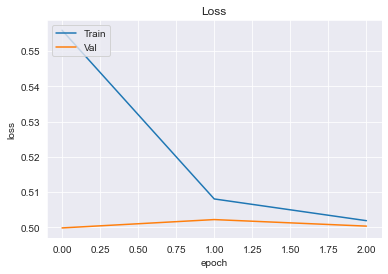

In [26]:
sns.set_style("darkgrid")
plt.plot(train_loss)
plt.plot(val_loss)
plt.title('Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.savefig("final_loss.pdf")
plt.show()

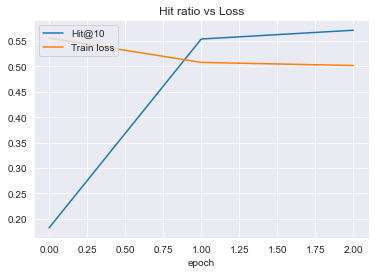

In [27]:


sns.set_style("darkgrid")
plt.plot(hits_list)
plt.plot(train_loss)
plt.title('Hit ratio vs Loss')
plt.xlabel('epoch')
plt.legend(['Hit@10', 'Train loss'], loc='upper left')
plt.savefig("final_hit_loss.pdf")
plt.show()

# 4.2 Popularity based

In [28]:
most_popular_df = pd.DataFrame(merged["article_id"].value_counts())
most_popular_df = most_popular_df.reset_index()
most_popular_df.columns=["article_id", "counts"]

In [29]:
most_popular_articles = most_popular_df["article_id"].values

In [30]:
def popularity_recommender(top_n, user_interactions, most_popular_articles,num_unique_users):
    """
    params: 
        top_n: number of articles to recommend
    """
    all_article_ids = merged["article_id"].unique()
    recommendations = {}
    for (u,i) in tqdm(user_interactions.items()):
        interacted_items = user_interactions[u]
        popular_items_not_interacted_with = []
        for i in range(10):
            counter = i
            popular_item = most_popular_articles[i]
            while popular_item in interacted_items:
                counter += 1
                popular_item = most_popular_articles[counter]
            popular_items_not_interacted_with.append(popular_item)
        recommendations[u] = list(popular_items_not_interacted_with)
    return recommendations

user_interactions = df_train.groupby("user_id")["article_id"].apply(list).to_dict()
num_unique_users = len(df_train["user_id"].unique())
recs = popularity_recommender(10, user_interactions, most_popular_articles, num_unique_users)

100%|██████████| 231/231 [00:00<00:00, 1874.56it/s]


{0: [1643, 1643, 2559, 1739, 2592, 2786, 1393, 4535, 551, 1528],
 1: [3563, 1643, 2559, 1739, 2592, 2786, 1393, 4535, 551, 1528],
 2: [3563, 1643, 2559, 1739, 2786, 2786, 1393, 4535, 551, 1528],
 3: [3563, 1643, 2559, 2592, 2592, 2786, 1393, 4535, 551, 1528],
 4: [3563, 1643, 2559, 1739, 2592, 2786, 1393, 4535, 551, 1528],
 5: [1643, 1643, 2559, 1739, 2592, 2786, 1393, 4535, 551, 3534],
 6: [3563, 1643, 2559, 1739, 2592, 2786, 1393, 4535, 551, 1528],
 7: [3563, 1643, 1739, 1739, 2592, 2786, 4535, 4535, 551, 1528],
 8: [2559, 2559, 2559, 1393, 1393, 1393, 1393, 3534, 3534, 3534],
 9: [3563, 1739, 1739, 1739, 2592, 2786, 1393, 4535, 551, 1528],
 10: [3563, 1643, 2559, 1739, 2592, 2786, 1393, 4535, 551, 1528],
 11: [3563, 1739, 1739, 1739, 2592, 2786, 1393, 1528, 1528, 1528],
 12: [3563, 1643, 2559, 1739, 2592, 2786, 1393, 4535, 551, 1528],
 13: [1643, 1643, 2559, 2592, 2592, 1393, 1393, 4535, 551, 1528],
 14: [3563, 1643, 2559, 1739, 2592, 2786, 1393, 4535, 551, 1528],
 15: [3563, 2559, 

In [32]:
users = df_test["user_id"].unique()
hit_ten = 0
hit_five = 0
for user_id in tqdm(users):
    user_df = df_test[df_test["user_id"]==user_id]
    true_item = userid_to_true_item[user_id] # get the actual true item in the test set
    recommendations = recs[user_id]
    five_recommendations = recommendations[:5]
    if true_item in recommendations:
        hit_ten+=1
    if true_item in five_recommendations:
        hit_five += 1
print(hit_ten/len(users))
print(hit_five / len(users))

100%|██████████| 231/231 [00:00<00:00, 696.73it/s]

0.047619047619047616
0.03463203463203463


# 4.3 Wide and deep - with features

In [33]:
def evaluate_one_rating_wide(model, user_id, user_profiles, all_articles,categories, sub_categories, true_item):
    ### Reshaping to make it on the right shape ###
    expanded_user_id = np.array([user_id]*100).reshape((100,1))
    all_articles = np.array(all_articles).reshape(-1,1)
    
    # predictions
    predictions = model.predict([expanded_user_id, user_profiles, all_articles,categories, sub_categories])
    predicted_labels = np.squeeze(predictions)
    #print(predicted_labels)
    top_ten_items = [all_articles[i] for i in np.argsort(predicted_labels)[::-1][0:10].tolist()]
    hr = getHitRatio(top_ten_items, true_item)
    ndcg = getNDCG(top_ten_items, true_item)
    hr_five = getHitRatio(top_ten_items[:5], true_item)
    ndcg_five = getNDCG(top_ten_items[:5], true_item)
    return hr, ndcg, hr_five, ndcg_five

def evalaute_model_wide(model, df_test, userid_to_true_item):
    print("Evaluate model")
    hits = []
    ndcgs = []
    hits_five, ndcgs_five = [], []
    users = df_test["user_id"].unique()[:400]
    for user_id in tqdm(users):
        user_df = df_test[df_test["user_id"] == user_id] # get the 100 samples for this user
        true_item = userid_to_true_item[user_id] # get the actual true item in the test set
        all_articles = user_df["article_id"].to_numpy().astype(int) # get all possible articles
        user_profiles = user_df.iloc[:, 1:7].to_numpy().astype(int)# get the user_profile
        
        categories = user_df.iloc[:, 8].to_numpy().astype(int)
        sub_categories = user_df.iloc[:, 9].to_numpy().astype(int)
        
        ht, ndcg, ht_five, ndcg_five = evaluate_one_rating_wide(model, user_id, user_profiles, all_articles,categories, sub_categories, true_item)
        hits.append(ht)
        ndcgs.append(ndcg)
        hits_five.append(ht_five)
        ndcgs_five.append(ndcg_five)
    return hits, ndcgs,hits_five,ndcgs_five

In [34]:
num_users = len(merged["user_id"].unique()) 
num_items = len(merged["article_id"].unique()) 
num_sub_categories = len(merged["subcategory_int"].unique())
num_categories = len(merged["category_int"].unique()) 
dims = 20

In [35]:
def get_model_wide(num_users, num_items, dims, dense_layers=[128, 64, 32, 8]):
    #### Matrix factorization ####
    user_id_input = Input(shape=[1], name="user_id")
    item_id_input = Input(shape=[1], name="item_id")
    user_embedding = Embedding(input_dim=num_users, 
                               output_dim=dims, 
                               input_length=1, 
                               embeddings_initializer='he_normal', 
                               embeddings_regularizer=regularizers.l2(0.001),
                               name="user_embedding")(user_id_input)
    item_embedding = Embedding(input_dim=num_items, 
                               output_dim=dims, 
                               embeddings_initializer='he_normal', 
                            embeddings_regularizer=regularizers.l2(0.001),
                               name="item_embedding")(item_id_input)
    
    user_flatten = Flatten()(user_embedding)
    item_flatten = Flatten()(item_embedding)
    mf_vec = Concatenate()([user_flatten, item_flatten])
    
    x_deep = Dense(128, activation="relu", kernel_initializer='he_uniform',kernel_regularizer=regularizers.l2(0.001))(mf_vec)
    x_deep = Dropout(0.2)(x_deep)
    x_deep = Dense(64, activation="relu",kernel_initializer='he_uniform', kernel_regularizer=regularizers.l2(0.001))(x_deep)
    x_deep = Dropout(0.2)(x_deep)
    
    #### Wide part ####
    
    user_profile_input = Input(shape=(6,), name="user_profile")
    item_category_input = Input(shape=(1,), name="category_input")
    item_sub_category_input = Input(shape=(1,), name="subcategory_input")
    
    item_category_emb = Embedding(input_dim=num_categories, output_dim=dims, name="category_emd", embeddings_regularizer=regularizers.l2(0.001))(item_category_input)
    item_subcategory_emb = Embedding(input_dim=num_sub_categories, output_dim=dims,embeddings_regularizer=regularizers.l2(0.001), name="subcat_emb")(item_sub_category_input)
    user_profile_emb = Embedding(input_dim=num_sub_categories, output_dim=dims,embeddings_regularizer=regularizers.l2(0.001), name="profile_emb")(user_profile_input)

    item_category_flatten = Flatten()(item_category_emb)
    item_subcategory_flatten = Flatten()(item_subcategory_emb)
    user_profile_flatten = Flatten()(user_profile_emb)
    
    wide_features = Concatenate()([item_category_flatten, item_subcategory_flatten,  user_profile_flatten])
    
    x_wide = Dense(128, activation="relu",kernel_initializer='he_uniform', kernel_regularizer=regularizers.l2(0.001))(wide_features)
    x_wide = Dropout(0.5)(x_wide)
    x_wide = Dense(64, activation="relu",kernel_initializer='he_uniform', kernel_regularizer=regularizers.l2(0.001))(x_wide)
    x_wide = Dropout(0.5)(x_wide)
    
    final = Concatenate()([x_deep,x_wide])
    x = Dense(128, kernel_initializer='he_uniform',activation="relu")(final)
    x = Dropout(0.5)(x)
    y = Dense(1, activation="sigmoid")(x)
    
    
    model = Model(inputs=[user_id_input, user_profile_input, item_id_input, item_category_input, item_sub_category_input], outputs=y)
    model.compile(
        optimizer=Adam(0.001),
        loss="binary_crossentropy",
        metrics=["accuracy"],
    )
    return model

model_wide = get_model_wide(num_users, num_items, dims)

In [36]:
###### Training ########
user_input = df_train.iloc[:, 0].values.reshape((-1,1))
profile_input = df_train.iloc[:, 1:7].values
item_input = df_train.iloc[:, 7].values.reshape((-1,1))
labels = df_train.iloc[:, 10].values.reshape((-1))
category_input = df_train.iloc[:, 8].values.reshape((-1,1))
sub_category_input = df_train.iloc[:, 9].values.reshape((-1,1))
print(user_input.shape,profile_input.shape, item_input.shape,category_input.shape, sub_category_input.shape, labels.shape )

(47485, 1) (47485, 6) (47485, 1) (47485, 1) (47485, 1) (47485,)


In [37]:
all_user_ids = df_train["user_id"].unique()

#user_input = df_train.iloc[:, 0].values.reshape((-1,1))
#profile_input = df_train.iloc[:, 1:6].values
#item_input = df_train.iloc[:, 7].values.reshape((-1,1))
#labels = df_train.iloc[:, 8].values.reshape((-1,1))

train_loss = []
val_loss = []
train_acc = []
val_acc = []

hits_list = []
ndcg_list = []
best_hits = 0
best_ndcgs = 0


epochs=3

for epoch in range(epochs):
    hist = model_wide.fit([user_input, profile_input, item_input,category_input,sub_category_input], labels,validation_split=0.1, epochs=1, shuffle=True, verbose=1)
    
    train_loss.append(hist.history["loss"])
    train_acc.append(hist.history["accuracy"])
    val_loss.append(hist.history["val_loss"])
    val_acc.append(hist.history["val_accuracy"])
    
    hits, ndcgs, hits_five, ndcgs_five = evalaute_model_wide( model_wide, df_test, userid_to_true_item)
    hits_list.append(np.average(hits))
    ndcg_list.append(np.average(ndcgs))
    
    temp_hits = np.average(hits)
    temp_ndcgs = np.average(ndcgs)
    if (temp_hits > best_hits):
        best_hits = temp_hits
        best_hits_five = np.average(hits_five)
        best_ndcgs_five = np.average(ndcgs_five)
        best_ndcgs = temp_ndcgs

1336/1336 [==============================] - 4s 2ms/step - loss: 0.7942 - accuracy: 0.7970 - val_loss: 0.5137 - val_accuracy: 0.8002


  0%|          | 1/231 [00:00<00:35,  6.44it/s]

Evaluate model


100%|██████████| 231/231 [00:10<00:00, 21.83it/s]


[0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1]
1336/1336 [==============================] - 3s 2ms/step - loss: 0.5059 - accuracy: 0.8014 - val_loss: 0.4906 - val_accuracy: 0.8090


  1%|▏         | 3/231 [00:00<00:11, 20.18it/s]

Evaluate model


100%|██████████| 231/231 [00:10<00:00, 21.21it/s]

[0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1]
  32/1336 [..............................] - ETA: 2s - loss: 0.4769 - accuracy: 0.8154

1336/1336 [==============================] - 2s 2ms/step - loss: 0.4922 - accuracy: 0.8069 - val_loss: 0.4830 - val_accuracy: 0.8122


  1%|          | 2/231 [00:00<00:13, 17.61it/s]

Evaluate model


100%|██████████| 231/231 [00:10<00:00, 21.37it/s]

[0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1]


In [38]:
print(best_hits)
print(best_ndcgs)
print(best_hits_five)
print(best_ndcgs_five)

0.2987012987012987
0.16063717750408954
0.18614718614718614
0.12393034296006351


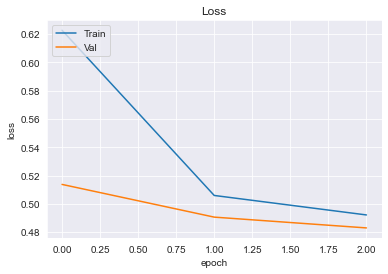

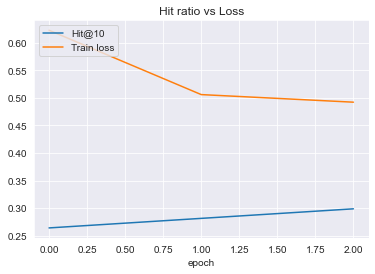

In [39]:
sns.set_style("darkgrid")
plt.plot(train_loss)
plt.plot(val_loss)
plt.title('Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.savefig("final_loss.pdf")
plt.show()

sns.set_style("darkgrid")
plt.plot(hits_list)
plt.plot(train_loss)
plt.title('Hit ratio vs Loss')
plt.xlabel('epoch')
plt.legend(['Hit@10', 'Train loss'], loc='upper left')
plt.savefig("final_hit_loss.pdf")
plt.show()

# 4.4 NCF

In [40]:
def evaluate_one_rating_ncf(model, user_id, all_articles, true_item):
    ### Reshaping to make it on the right shape ###
    expanded_user_id = np.array([user_id]*100).reshape((100,1))
    all_articles = np.array(all_articles).reshape(-1,1)
    
    # predictions
    predictions = model.predict([expanded_user_id, all_articles])
    predicted_labels = np.squeeze(predictions)
    top_ten_items = [all_articles[i] for i in np.argsort(predicted_labels)[::-1][0:10].tolist()]
    hr = getHitRatio(top_ten_items, true_item)
    ndcg = getNDCG(top_ten_items, true_item)
    hr_five = getHitRatio(top_ten_items[:5], true_item)
    ndcg_five = getNDCG(top_ten_items[:5], true_item)
    return hr, ndcg,hr_five,ndcg_five

def evalaute_model_ncf(model, df_test, userid_to_true_item):
    print("Evaluate model")
    hits = []
    ndcgs = []
    hits_five, ndcgs_five = [], []
    users = df_test["user_id"].unique()[:400]
    for user_id in tqdm(users):
        user_df = df_test[df_test["user_id"] == user_id] # get the 100 samples for this user
        true_item = userid_to_true_item[user_id] # get the actual true item in the test set
        all_articles = user_df["article_id"].to_numpy().astype(int) # get all possible articles
        
        ht, ndcg, ht_five, ndcg_five = evaluate_one_rating_ncf(model, user_id, all_articles, true_item)
        hits.append(ht)
        ndcgs.append(ndcg)
        hits_five.append(ht_five)
        ndcgs_five.append(ndcg_five)
    return hits, ndcgs,hits_five,ndcgs_five

In [41]:
def get_model_ncf(num_users, num_items, dims, dense_layers=[128, 64, 32, 8]):
    user_input = Input(shape=(1,), name="user")
    item_input = Input(shape=(1,), name="item")
    
    user_emb = Embedding(output_dim=dims, 
                         input_dim=num_users, 
                         input_length=1, 
                         embeddings_initializer='he_normal', 
                        embeddings_regularizer=regularizers.l2(0.001),
                         name="mf_user_emb")(user_input)
    item_emb = Embedding(output_dim=dims, 
                         input_dim=num_items, 
                         input_length=1, 
                         embeddings_initializer='he_normal', 
                        embeddings_regularizer=regularizers.l2(0.001),
                         name="mf_item_emb")(item_input)
    
    user_vecs = Reshape([dims])(user_emb)
    item_vecs = Reshape([dims])(item_emb)
    
    y = Dot(1, normalize=False)([user_vecs, item_vecs])
    
    y = Dense(1, activation="sigmoid")(y)
    
    
    model = Model(inputs=[user_input, item_input], outputs=y)
    model.compile(
        optimizer=Adam(0.01),
        loss="mse",
        metrics=["accuracy"],
    )
    return model

model_ncf = get_model_ncf(num_users, num_items, dims)

In [42]:
user_input = df_train.iloc[:, 0].values.reshape((-1,1))
item_input = df_train.iloc[:, 7].values.reshape((-1,1))
labels = df_train.iloc[:, 10].values.reshape((-1,1))
print(user_input.shape, item_input.shape, labels.shape )

(47485, 1) (47485, 1) (47485, 1)


In [43]:

all_user_ids = df_train["user_id"].unique()

#user_input = df_train.iloc[:, 0].values.reshape((-1,1))
#profile_input = df_train.iloc[:, 1:6].values
#item_input = df_train.iloc[:, 7].values.reshape((-1,1))
#labels = df_train.iloc[:, 8].values.reshape((-1,1))


train_loss = []
val_loss = []
train_acc = []
val_acc = []

hits_list = []
ndcg_list = []
best_hits = 0
best_ndcgs = 0
best_hits_five = 0
best_ndcgs_five = 0

epochs=3
for epoch in range(epochs):
    hist = model_ncf.fit([user_input, item_input], labels, epochs=1, shuffle=True, verbose=1, validation_split=0.1)
    
    train_loss.append(hist.history["loss"])
    train_acc.append(hist.history["accuracy"])
    val_loss.append(hist.history["val_loss"])
    val_acc.append(hist.history["val_accuracy"])
    
    hits, ndcgs, ht_five, ndcg_five = evalaute_model_ncf( model_ncf, df_test, userid_to_true_item)
    hits_list.append(np.average(hits))
    ndcg_list.append(np.average(ndcgs))
    
    temp_hits = np.average(hits)
    temp_ndcgs = np.average(ndcgs)
    if (temp_hits > best_hits):
        best_hits = temp_hits
        best_hits_five = np.average(ht_five)
        best_ndcgs_five = np.average(ndcg_five)
        best_ndcgs = temp_ndcgs
    

1336/1336 [==============================] - 2s 1ms/step - loss: 0.1761 - accuracy: 0.7971 - val_loss: 0.1599 - val_accuracy: 0.8002


  1%|          | 2/231 [00:00<00:15, 15.25it/s]

Evaluate model


100%|██████████| 231/231 [00:09<00:00, 23.33it/s]


1336/1336 [==============================] - 2s 1ms/step - loss: 0.1601 - accuracy: 0.8000 - val_loss: 0.1600 - val_accuracy: 0.8002


  1%|▏         | 3/231 [00:00<00:10, 22.20it/s]

Evaluate model


100%|██████████| 231/231 [00:09<00:00, 23.83it/s]

  45/1336 [>.............................] - ETA: 1s - loss: 0.1635 - accuracy: 0.7944

1336/1336 [==============================] - 2s 1ms/step - loss: 0.1601 - accuracy: 0.8000 - val_loss: 0.1600 - val_accuracy: 0.8002


  0%|          | 0/231 [00:00<?, ?it/s]

Evaluate model


100%|██████████| 231/231 [00:09<00:00, 25.37it/s]


In [44]:
print(best_hits)
print(best_ndcgs)
print(best_hits_five)
print(best_ndcgs_five)

0.6363636363636364
0.4817469341103242
0.5887445887445888
0.46568862463810606


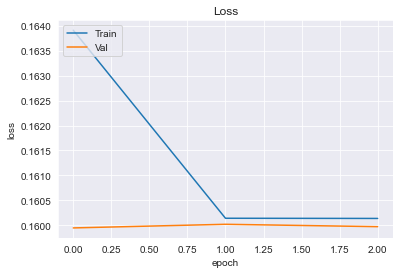

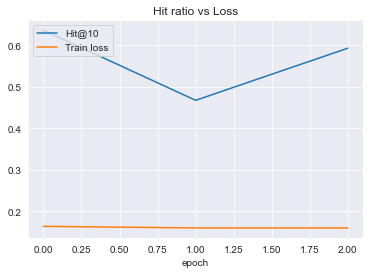

In [45]:
sns.set_style("darkgrid")
plt.plot(train_loss)
plt.plot(val_loss)
plt.title('Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.savefig("final_loss.pdf")
plt.show()

sns.set_style("darkgrid")
plt.plot(hits_list)
plt.plot(train_loss)
plt.title('Hit ratio vs Loss')
plt.xlabel('epoch')
plt.legend(['Hit@10', 'Train loss'], loc='upper left')
plt.savefig("final_hit_loss.pdf")
plt.show()

# 4.5 NeuMF with features

In [46]:
def evaluate_one_rating_neumffeat(model, user_id, user_profiles, all_articles,categories, sub_categories, true_item):
    ### Reshaping to make it on the right shape ###
    expanded_user_id = np.array([user_id]*100).reshape((100,1))
    all_articles = np.array(all_articles).reshape(-1,1)
    
    # predictions
    predictions = model.predict([expanded_user_id, user_profiles, all_articles,categories, sub_categories])
    predicted_labels = np.squeeze(predictions)
    #print(predicted_labels)
    top_ten_items = [all_articles[i] for i in np.argsort(predicted_labels)[::-1][0:10].tolist()]
    hr = getHitRatio(top_ten_items, true_item)
    ndcg = getNDCG(top_ten_items, true_item)
    hr_five = getHitRatio(top_ten_items[:5], true_item)
    ndcg_five = getNDCG(top_ten_items[:5], true_item)
    return hr, ndcg, hr_five, ndcg_five

def evalaute_model_neumffeat(model, df_test, userid_to_true_item):
    print("Evaluate model")
    hits = []
    ndcgs = []
    hits_five, ndcgs_five = [], []
    users = df_test["user_id"].unique()[:400]
    for user_id in tqdm(users):
        user_df = df_test[df_test["user_id"] == user_id] # get the 100 samples for this user
        true_item = userid_to_true_item[user_id] # get the actual true item in the test set
        all_articles = user_df["article_id"].to_numpy().astype(int) # get all possible articles
        user_profiles = user_df.iloc[:, 1:7].to_numpy().astype(int)# get the user_profile
        
        categories = user_df.iloc[:, 8].to_numpy().astype(int)
        sub_categories = user_df.iloc[:, 9].to_numpy().astype(int)
        
        ht, ndcg, ht_five, ndcg_five = evaluate_one_rating_neumffeat(model, user_id, user_profiles, all_articles,categories, sub_categories, true_item)
        hits.append(ht)
        ndcgs.append(ndcg)
        hits_five.append(ht_five)
        ndcgs_five.append(ndcg_five)
    return hits, ndcgs,hits_five,ndcgs_five

In [47]:
num_users = len(merged["user_id"].unique())
num_items = len(merged["article_id"].unique())
dims = 20
def get_model_neumffeat(num_users, num_items, dims, dense_layers=[128, 64, 32, 8]):
    user_input = Input(shape=(1,), name="user")
    item_input = Input(shape=(1,), name="item")
    
    mf_user_emb = Embedding(output_dim=dims, 
                            input_dim=num_users, 
                            input_length=1, 
                            embeddings_initializer='he_normal', 
                            embeddings_regularizer=regularizers.l2(0.001),
                            name="mf_user_emb")(user_input)
    mf_item_emb = Embedding(output_dim=dims, 
                            input_dim=num_items, 
                            input_length=1, 
                            embeddings_initializer='he_normal', 
                            embeddings_regularizer=regularizers.l2(0.001),
                            name="mf_item_emb")(item_input)
    
    num_layers = len(dense_layers)
    mlp_user_emb = Embedding(output_dim=int(dense_layers[0] / 2), 
                             input_dim=num_users, 
                             input_length=1, 
                             embeddings_initializer='he_normal', 
                             embeddings_regularizer=regularizers.l2(0.001),
                             name="mlp_user_emb")(user_input)
    mlp_item_emb = Embedding(output_dim=int(dense_layers[0] / 2), 
                             input_dim=num_items, 
                             input_length=1, 
                             embeddings_initializer='he_normal', 
                            embeddings_regularizer=regularizers.l2(0.001),
                             name="mlp_user_item")(item_input)
    
    # Matrix factorization
    mf_user_vecs = Reshape([dims])(mf_user_emb)
    mf_item_vecs = Reshape([dims])(mf_item_emb)
    
    mf_vec = multiply([mf_user_vecs, mf_item_vecs])
    
    #MLP
    profile_input = Input(shape=(6,), name="user_profile")
    category_input = Input(shape=(1,), name="category_input")
    sub_category_input = Input(shape=(1,), name="subcategory_input")
    
    item_category_emb = Embedding(input_dim=num_categories, output_dim=int(dense_layers[0] / 2), name="category_emd", embeddings_regularizer=regularizers.l2(0.001))(category_input)
    item_subcategory_emb = Embedding(input_dim=num_sub_categories, output_dim=int(dense_layers[0] / 2),embeddings_regularizer=regularizers.l2(0.001), name="subcat_emb")(sub_category_input)
    user_profile_emb = Embedding(input_dim=num_sub_categories, output_dim=int(dense_layers[0] / 2),embeddings_regularizer=regularizers.l2(0.001), name="profile_emb")(profile_input)

    item_category_flatten = Flatten()(item_category_emb)
    item_subcategory_flatten = Flatten()(item_subcategory_emb)
    user_profile_flatten = Flatten()(user_profile_emb)
    
    wide_features = Concatenate()([item_category_flatten, item_subcategory_flatten,  user_profile_flatten])
    mlp_vector = Flatten()(wide_features)
    for num_dense in dense_layers:
        l = Dense(num_dense, activation="relu")
        mlp_vector = l(mlp_vector)
        mlp_vector = Dropout(0.2)(mlp_vector)
    

    
    mlp_vec = Concatenate()([mlp_user_emb, mlp_item_emb])
    mlp_vector = Flatten()(mlp_vec)
    
    y = Concatenate()([mf_vec, mlp_vector])
    y = Dense(1, activation="sigmoid", name="pred")(y)
    
    
    model = Model(inputs=[user_input, profile_input, item_input,category_input,sub_category_input], outputs=y)
    model.compile(
        optimizer=Adam(0.01),
        loss="binary_crossentropy",
        metrics=["accuracy"],
    )
    return model

model_neumffeat = get_model_neumffeat(num_users, num_items, dims)

In [48]:
###### Training ########
user_input = df_train.iloc[:, 0].values.reshape((-1,1))
profile_input = df_train.iloc[:, 1:7].values
item_input = df_train.iloc[:, 7].values.reshape((-1,1))
labels = df_train.iloc[:, 10].values.reshape((-1))
category_input = df_train.iloc[:, 8].values.reshape((-1,1))
sub_category_input = df_train.iloc[:, 9].values.reshape((-1,1))
print(user_input.shape,profile_input.shape, item_input.shape,category_input.shape, sub_category_input.shape, labels.shape )

(47485, 1) (47485, 6) (47485, 1) (47485, 1) (47485, 1) (47485,)


In [49]:
all_user_ids = df_train["user_id"].unique()

#user_input = df_train.iloc[:, 0].values.reshape((-1,1))
#profile_input = df_train.iloc[:, 1:6].values
#item_input = df_train.iloc[:, 7].values.reshape((-1,1))
#labels = df_train.iloc[:, 8].values.reshape((-1,1))

train_loss = []
val_loss = []
train_acc = []
val_acc = []

hits_list = []
ndcg_list = []
best_hits = 0
best_ndcgs = 0


epochs=3

for epoch in range(epochs):
    hist = model_neumffeat.fit([user_input, profile_input, item_input,category_input,sub_category_input], labels,validation_split=0.1, epochs=1, shuffle=True, verbose=1)
    
    train_loss.append(hist.history["loss"])
    train_acc.append(hist.history["accuracy"])
    val_loss.append(hist.history["val_loss"])
    val_acc.append(hist.history["val_accuracy"])
    
    hits, ndcgs, hits_five, ndcgs_five = evalaute_model_neumffeat( model_neumffeat, df_test, userid_to_true_item)
    hits_list.append(np.average(hits))
    ndcg_list.append(np.average(ndcgs))
    
    temp_hits = np.average(hits)
    temp_ndcgs = np.average(ndcgs)
    if (temp_hits > best_hits):
        best_hits = temp_hits
        best_hits_five = np.average(hits_five)
        best_ndcgs_five = np.average(ndcgs_five)
        best_ndcgs = temp_ndcgs

1336/1336 [==============================] - 4s 2ms/step - loss: 0.5987 - accuracy: 0.7876 - val_loss: 0.5356 - val_accuracy: 0.8004


  0%|          | 1/231 [00:00<00:26,  8.82it/s]

Evaluate model


100%|██████████| 231/231 [00:10<00:00, 21.18it/s]


[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0]
1336/1336 [==============================] - 3s 2ms/step - loss: 0.5444 - accuracy: 0.8020 - val_loss: 0.5306 - val_accuracy: 0.8031


  1%|          | 2/231 [00:00<00:11, 19.64it/s]

Evaluate model


100%|██████████| 231/231 [00:10<00:00, 21.04it/s]

[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1]
  26/1336 [..............................] - ETA: 2s - loss: 0.5142 - accuracy: 0.8101

1336/1336 [==============================] - 3s 2ms/step - loss: 0.5496 - accuracy: 0.8026 - val_loss: 0.5318 - val_accuracy: 0.8054


  1%|          | 2/231 [00:00<00:12, 17.84it/s]

Evaluate model


100%|██████████| 231/231 [00:11<00:00, 20.52it/s]

[1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1]


In [50]:
print(best_hits)
print(best_ndcgs)
print(best_hits_five)
print(best_ndcgs_five)

0.22943722943722944
0.1498895696930133
0.18614718614718614
0.1360791781847107


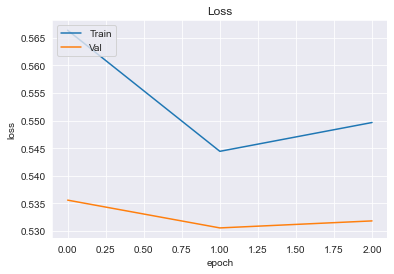

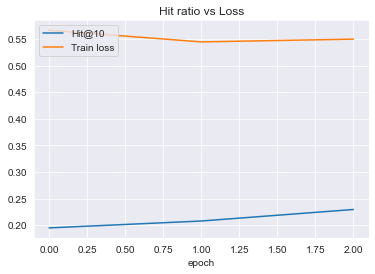

In [51]:
sns.set_style("darkgrid")
plt.plot(train_loss)
plt.plot(val_loss)
plt.title('Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.savefig("final_loss.pdf")
plt.show()

sns.set_style("darkgrid")
plt.plot(hits_list)
plt.plot(train_loss)
plt.title('Hit ratio vs Loss')
plt.xlabel('epoch')
plt.legend(['Hit@10', 'Train loss'], loc='upper left')
plt.savefig("final_hit_loss.pdf")
plt.show()